In [2]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import numpy as np

import jax
import jax.numpy as jnp
from functools import partial

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

(array([[-1.07743742,  1.05170098, -0.04042656],
       [-0.83572923, -0.67611045, -1.05512708],
       [-0.43919561, -0.45125586,  1.29967105]]), array([[-0.31404008,  0.01073449, -0.00480561],
       [ 0.6368116 ,  0.7752852 , -0.57146199],
       [-0.5578269 ,  0.46305489, -0.55300808]]), array([[2.09929103, 0.        , 0.        ],
       [0.        , 1.30360208, 0.        ],
       [0.        , 0.        , 0.06230467]]), array([[ 1.45325963e+00,  1.08246745e-15,  2.04003481e-15],
       [ 1.08246745e-15,  1.45325963e+00, -6.88338275e-15],
       [ 2.04003481e-15, -6.88338275e-15,  1.45325963e+00]]))


In [3]:
bc = BlindColours(False)
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()
colour_steps = bc.get_colour_steps()

In [4]:
def logger(params, X, Y, f):
    w2w1 = params["network"]["layer-1"]["w"][0] @ params["network"]["layer-0"]["w"][0]
    Y_hat = params["network"]["layer-1"]["w"][0] @ f(params["network"]["layer-0"]["w"][0] @ X.T)
    loss = 0.5 * np.mean(np.sum((Y_hat.T - Y)**2, axis=1))
    return w2w1, loss

In [5]:
np.random.seed(2)

in_dim = 5
hidden_dim = 10
out_dim = 6

batch_size = 25
learning_rate = 0.05
training_steps = 6000

initial_weight_scale = 0.0001

training_datas = []
for i in range(4):
    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, 0.3)
    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    training_datas.append(training_data)

losses = [[] for _ in range(4)]

logs = jax.jit(partial(logger, f=gs.nonlinearities.Identity()))

ws = []
analyticals = []
for i, training_data in enumerate(training_datas):
    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    if i == 0:
        init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_weight_scale)
    else:
        init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])
    
    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)
    
    for training_step in range(training_steps):
        for j, data in enumerate(training_datas):
            X, Y = data(None)
            w2w1, loss = logs(params, X, Y)
            losses[j].append(loss)
        ws.append(w2w1)
        
        state, params, loss = trainer(state, params)
    
    X, Y = training_data(None)
    analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    analyticals.append(np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)]))

ws = np.asarray(ws)
losses = np.asarray(losses)
analyticals = np.asarray(analyticals)

In [7]:
losses.shape

(4, 24000)

In [6]:
ws.shape

(24000, 6, 5)

In [6]:
losses

array([[0.48605335, 0.48605335, 0.48605335, ..., 0.6476811 , 0.6476811 ,
        0.6476811 ],
       [0.45535448, 0.45535448, 0.45535448, ..., 0.57818586, 0.57818586,
        0.57818586],
       [0.4645389 , 0.4645389 , 0.4645389 , ..., 0.5905383 , 0.5905383 ,
        0.5905383 ],
       [0.43152905, 0.43152905, 0.43152905, ..., 0.33318928, 0.33318928,
        0.33318928]], dtype=float32)

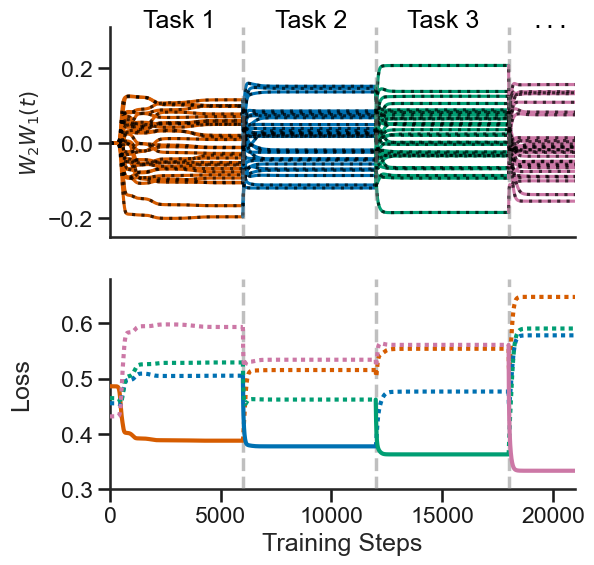

In [5]:
last_task_lim = training_steps // 2
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

for i, (colour, rng) in enumerate(zip(blind_colours, [training_steps * j for j in range(1, 4)] + [training_steps * 4 - 1])):
    start = rng - training_steps
    end = rng
    axs[0].plot(range(start, end), ws[start:end].reshape(-1, in_dim * out_dim), c=colour)
    for j in range(2):
        axs[j].axvline(end, linestyle="--", c="grey", alpha=0.5, lw=2.5, zorder=3)
        
    for j, (colour, loss) in enumerate(zip(blind_colours, losses)):
        if i != j:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., linestyle=(0, (1, 1)), zorder=4)
        else:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., zorder=4)
axs[0].plot(analyticals.reshape(-1, in_dim * out_dim)[:-last_task_lim], c="k", alpha=0.7, linestyle=(0, (1, 2)))

for i in range(2):
    axs[i].set_xlim(0., end-last_task_lim)

axs[0].set_ylim(-.25, .31)
axs[0].set_yticks([-.2, 0., .2])
axs[0].set_xticks([])

axs[1].set_ylim(0.3, .68)
#axs[1].set_yticks([0., 5.])
axs[1].set_xticks(range(0, 20001, 5000))

for i, x_pos in enumerate([0.18, 0.40, 0.62]):
    fig.text(x_pos, 0.88, f"Task {i+1}", fontsize=18, c="k")
fig.text(0.83, 0.88, "$...$", fontsize=18, c="k")

axs[0].set_ylabel("$W_2W_1(t)$", fontsize=15)
axs[1].set_ylabel("Loss", labelpad=20.)
axs[1].set_xlabel("Training Steps")

sns.despine()
fig.savefig("./figures/figure-5_a.svg")

In [8]:
def calculate_forgetting(X1, Y1, X2, Y2):
    # Analytical gorgetting
    t1 = 1. / batch_size * Y1.T @ X1
    s1 = t1.flatten()
    t2 = 1. / batch_size * Y2.T @ X2
    s2 = t2.flatten()

    n1 = np.linalg.norm(s1)
    n2 = np.linalg.norm(s2)

    theta = (s1 @ s2) / (n1 * n2)
    return (0.5 * n1**2 + 0.5 * n2**2 - n1 * n2 * theta)

def calculate_forgetting_2(s1, s2):
    # Analytical gorgetting
    s1 = s1.flatten()
    s2 = s2.flatten()
    
    n1 = np.linalg.norm(s1)
    n2 = np.linalg.norm(s2)

    theta = (s1 @ s2) / (n1 * n2)
    return (0.5 * n1**2 + 0.5 * n2**2 - n1 * n2 * theta)

def calculate_balancedness(params):
    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    return jnp.linalg.norm(w1@w1.T - w2.T@w2, ord="fro") #**2

calculate_balancedness = jax.jit(calculate_balancedness)

In [13]:
real_forgetting = []
analytical_forgetting = []
balancedness = []

runs_n = 50

for nonlinearity in [gs.nonlinearities.Identity(), gs.nonlinearities.Tanh(), gs.nonlinearities.ReLU()]:
    np.random.seed(1)
    
    logs = jax.jit(partial(logger, f=nonlinearity))
    for run in range(runs_n):
        in_dim = np.random.randint(2, 31)
        out_dim = np.random.randint(2, 31)
        hidden_dim = np.random.randint(np.min([in_dim, out_dim]), 31)
        
        fnct_name = str(nonlinearity).split(" ")[1].split(".")[0].lower()
        print(fnct_name, run, ", dims:", in_dim, hidden_dim, out_dim, "   ", end="\r")
        
        batch_size = 100
        learning_rate = 0.075
        if fnct_name == "identity":
            training_steps = 5000
        else:
            training_steps = 50000
        target_std = .5 / np.sqrt(np.mean([in_dim, hidden_dim]))

        training_data_1, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
        training_data_2, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])

        X1, Y1 = training_data_1(None)
        X2, Y2 = training_data_2(None)
        
        balancedness_ = []
        
        for i, training_data in enumerate([training_data_1, training_data_2]):
            task = gs.tasks.FullBatchLearning(training_data)
            optimiser = gs.GradientDescent(learning_rate)
            loss = gs.MeanSquaredError()

            if i == 0:
                init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, target_std)
            else:
                init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]
            
            mlp = gs.Network([
                gs.Linear(hidden_dim, False, nonlinearity, weight_init=gs.init.FromFixedValue(init_w1)),
                gs.Linear(out_dim, False, weight_init=gs.init.FromFixedValue(init_w2))
            ])

            trainer = gs.Trainer(task, mlp, loss, optimiser)
            state, params = gs.assemble(1)

            for training_step in range(training_steps):
                if training_step == 0:
                    balancedness_.append(calculate_balancedness(params))
                state, params, loss = trainer(state, params)
            
            if i == 0:
                _, initial_task_1_loss = logs(params, X1, Y1)
        _, final_task_1_loss = logs(params, X1, Y1)
        
        balancedness_.append(calculate_balancedness(params))
        
        balancedness.append(balancedness_)
        analytical_forgetting.append(calculate_forgetting(X1, Y1, X2, Y2))
        real_forgetting.append(final_task_1_loss - initial_task_1_loss)
    print(fnct_name, "done                          ")

identity done                          
tanh done                          
relu done                          


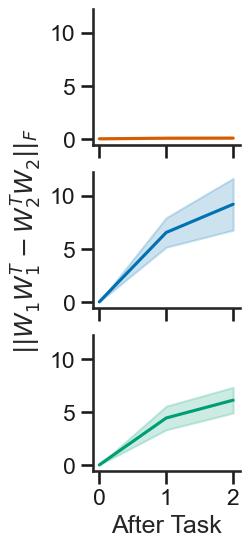

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(1.9, 6), sharex=True, sharey=True)
increment = runs_n
start = 0
end = increment
for i, colour in enumerate(blind_colours[0:3]):
    mean = np.mean(np.sqrt(balancedness[start:end]), axis=0)
    std = np.std(np.sqrt(balancedness[start:end]), axis=0)
    axs[i].fill_between(range(3), mean-std, mean+std, color=colour, alpha=0.2)
    axs[i].plot(mean, c=colour)
    start += increment
    end += increment
    axs[i].set_xticks([0, 1, 2])
    axs[i].set_yticks([0, 5, 10])
    
axs[1].set_ylabel("$||W_1^{}W_1^T - W_2^TW_2^{}||_F$")
axs[2].set_xlabel("After Task")

sns.despine()

fig.savefig("./figures/figure-5_c.svg")

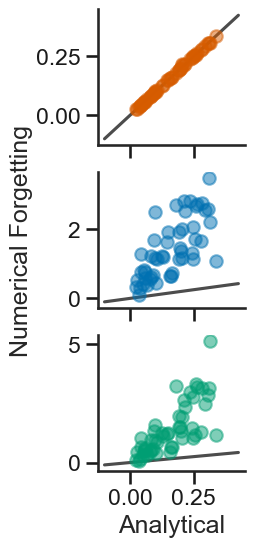

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(1.9, 6), sharex=True)
increment = runs_n
start = 0
end = increment
for i, colour in enumerate(blind_colours[0:3]):
    axs[i].scatter(analytical_forgetting[start:end], real_forgetting[start:end], alpha=0.5, color=colour, zorder=2)
    start += increment
    end += increment
    axs[i].plot(np.linspace(-0.1, .425), np.linspace(-0.1, .425), c="k", alpha=0.7, zorder=1)

axs[1].set_ylabel("Numerical Forgetting", labelpad=25)
axs[2].set_xlabel("Analytical")

sns.despine()
fig.savefig("./figures/figure-5_b.svg")

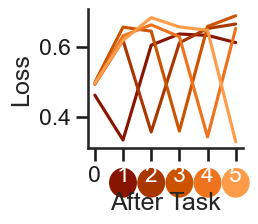

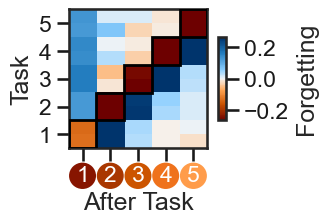

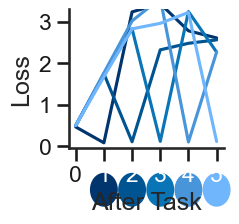

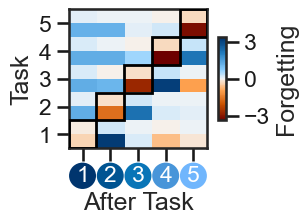

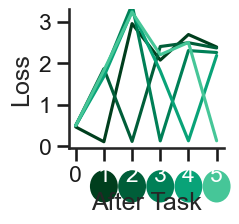

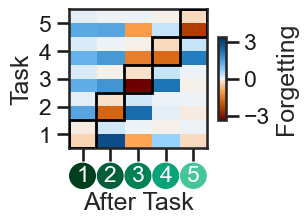

In [17]:
in_dim = 15
hidden_dim = 18
out_dim = 21

batch_size = 50
learning_rate = 0.1
training_steps = 20000

target_std = 0.025
tasks_n = runs_n = 5

training_datas = []
for i in range(tasks_n):
    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    training_datas.append(training_data)

task_order = np.arange(runs_n)

for k, f in enumerate([gs.nonlinearities.Identity(), gs.nonlinearities.Tanh(), gs.nonlinearities.ReLU()]):
    np.random.seed(1)
    losses = [[] for _ in range(tasks_n)]
    analytical_forgetting = [[] for _ in range(tasks_n)]

    logs = jax.jit(partial(logger, f=f))

    for i, dataset in enumerate(task_order):
        training_data = training_datas[dataset]
        X1, Y1 = training_data(None)
        task = gs.tasks.FullBatchLearning(training_data)
        optimiser = gs.GradientDescent(learning_rate)
        loss = gs.MeanSquaredError()

        if i == 0:
            init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, target_std)
        else:
            init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]

        mlp = gs.Network([
            gs.Linear(hidden_dim, False, f, weight_init=gs.init.FromFixedValue(init_w1)),
            gs.Linear(out_dim, False, weight_init=gs.init.FromFixedValue(init_w2))
        ])

        trainer = gs.Trainer(task, mlp, loss, optimiser)
        state, params = gs.assemble(1)

        if i == 0:
            # Initial loss
            for j, data in enumerate(training_datas):
                X2, Y2 = data(None)
                _, l = logs(params, X2, Y2)
                losses[j].append(l)
                analytical_forgetting[j].append(calculate_forgetting_2(1. / batch_size * Y2.T @ X2, init_w2@init_w1))

        for training_step in range(training_steps):
            state, params, _ = trainer(state, params)

        for j, data in enumerate(training_datas):
            X2, Y2 = data(None)
            _, l = logs(params, X2, Y2)
            losses[j].append(l)
            X1, Y1 = training_data(None)
            analytical_forgetting[j].append(calculate_forgetting(X1, Y1, X2, Y2))

    losses = np.asarray(losses)
    analytical_forgetting = np.asarray(analytical_forgetting)
    
    fig, ax = plt.subplots(figsize=(2., 1.8))
    for i, loss in enumerate(losses):
        ax.plot(loss, c=colour_steps[k][i])

    ax.set_xticks(range(tasks_n+1))
    ratio = ax.get_data_ratio() * 1.2
    radius = 0.2 * np.diff(ax.get_ylim())
    y_pos = ax.get_ylim()[0] - np.diff(ax.get_ylim()) * 0.25
    for i, tick in enumerate(ax.get_xticklabels()):
        if i == 0:
            continue
        c = Ellipse((1.*i, y_pos), radius/ratio, radius, color=colour_steps[k][i-1])
        c.set_clip_on(False)
        c.set_zorder(-1)
        ax.add_artist(c)
        tick.set_color("white")
    ax.set_ylabel("Loss")
    ax.set_xlabel("After Task")
    
    if k == 0:
        ax.set_yticks([0.4, 0.6])
    else:
        ax.set_yticks([0, 1, 2, 3])
        ax.set_ylim(-0.05, 3.3)
        
    sns.despine()
    fig.savefig("./figures/figure-5_d-" + str(k) + ".svg")
    
    numerical_forgettings = []
    for task in range(tasks_n):
        numerical_forgetting = []
        for run in range(runs_n):
            f = losses[task, run+1] - losses[task, run]
            numerical_forgetting.append(f)
        numerical_forgettings.append(numerical_forgetting)
    
    analytical_forgetting_ = np.diff(analytical_forgetting, axis=1)
    forgettings = np.hstack([numerical_forgettings, analytical_forgetting_]).reshape(tasks_n*2, runs_n)

    def highlight_cell(x, y, ax=None):
        rect = plt.Rectangle((x - .5, (y - 0.25)*2), 1, 2, fill=False, color="k", lw=2., zorder=100)
        ax.add_patch(rect)

    fig, ax = plt.subplots(figsize=(2.8, 1.8))
    
    if k == 0:
        lim = 0.25
    else:
        lim = 3.2
    
    vals = ax.matshow(forgettings, aspect=0.5, cmap=div_cmap, vmin=-lim*1.05, vmax=lim*1.05)
    for i, task in enumerate(task_order):
        highlight_cell(i, task, ax)

    ax.xaxis.tick_bottom()
    ax.set_xticks(range(runs_n))
    ax.set_xticklabels(task_order+1)
    ax.set_xlabel("After Task")
    ax.set_ylabel("Task")
    ax.set_xlim(-0.5, runs_n-.5)
    ax.set_ylim(-0.5, 9.5)
    ax.set_yticks(np.linspace(.5, 8.5, 5))
    ax.set_yticklabels(range(1, 6))
    cbar = fig.colorbar(vals, shrink=0.6, aspect=10)
    cbar.set_label("Forgetting")
    
    ratio = 1.95
    radius = 1.75
    y_pos = -2.5
    for i, tick in enumerate(ax.get_xticklabels()):
        c = Ellipse((1.*i, y_pos), radius/ratio, radius, color=colour_steps[k][i])
        c.set_clip_on(False)
        c.set_zorder(-1)
        ax.add_artist(c)
        tick.set_color("white")
    
    if k == 0:
        cbar.set_ticks([-0.2, 0., 0.2])
    else:
        cbar.set_ticks([-3., 0., 3.])
    
    fig.savefig("./figures/figure-5_e-" + str(k) + ".svg")